In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test


In [3]:
df = pd.read_csv("../Data Preparation/training_data_50.csv")

We only select the columns which do not have a lot of categories to reduce the number of columns for our Cox Model analysis.

In [4]:

# 1. Drop identifier column
df = df.drop(columns=['participant_id'])
cardinality = 3
# 2. Convert categorical variables to dummy variables
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
high_cardinality_cols = [col for col in categorical_cols if df[col].nunique() > cardinality]
low_cardinality_cols = [col for col in categorical_cols if df[col].nunique() <= cardinality] 
# Drop them from the dataframe
df = df.drop(columns=high_cardinality_cols)

In [5]:


df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

# 3. Define duration and event columns
duration_col = 'visit_month'
event_col = 'FOG'

# 4. Initialize and fit Cox model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df, duration_col=duration_col, event_col=event_col)

# 5. Output results
results = cph.summary

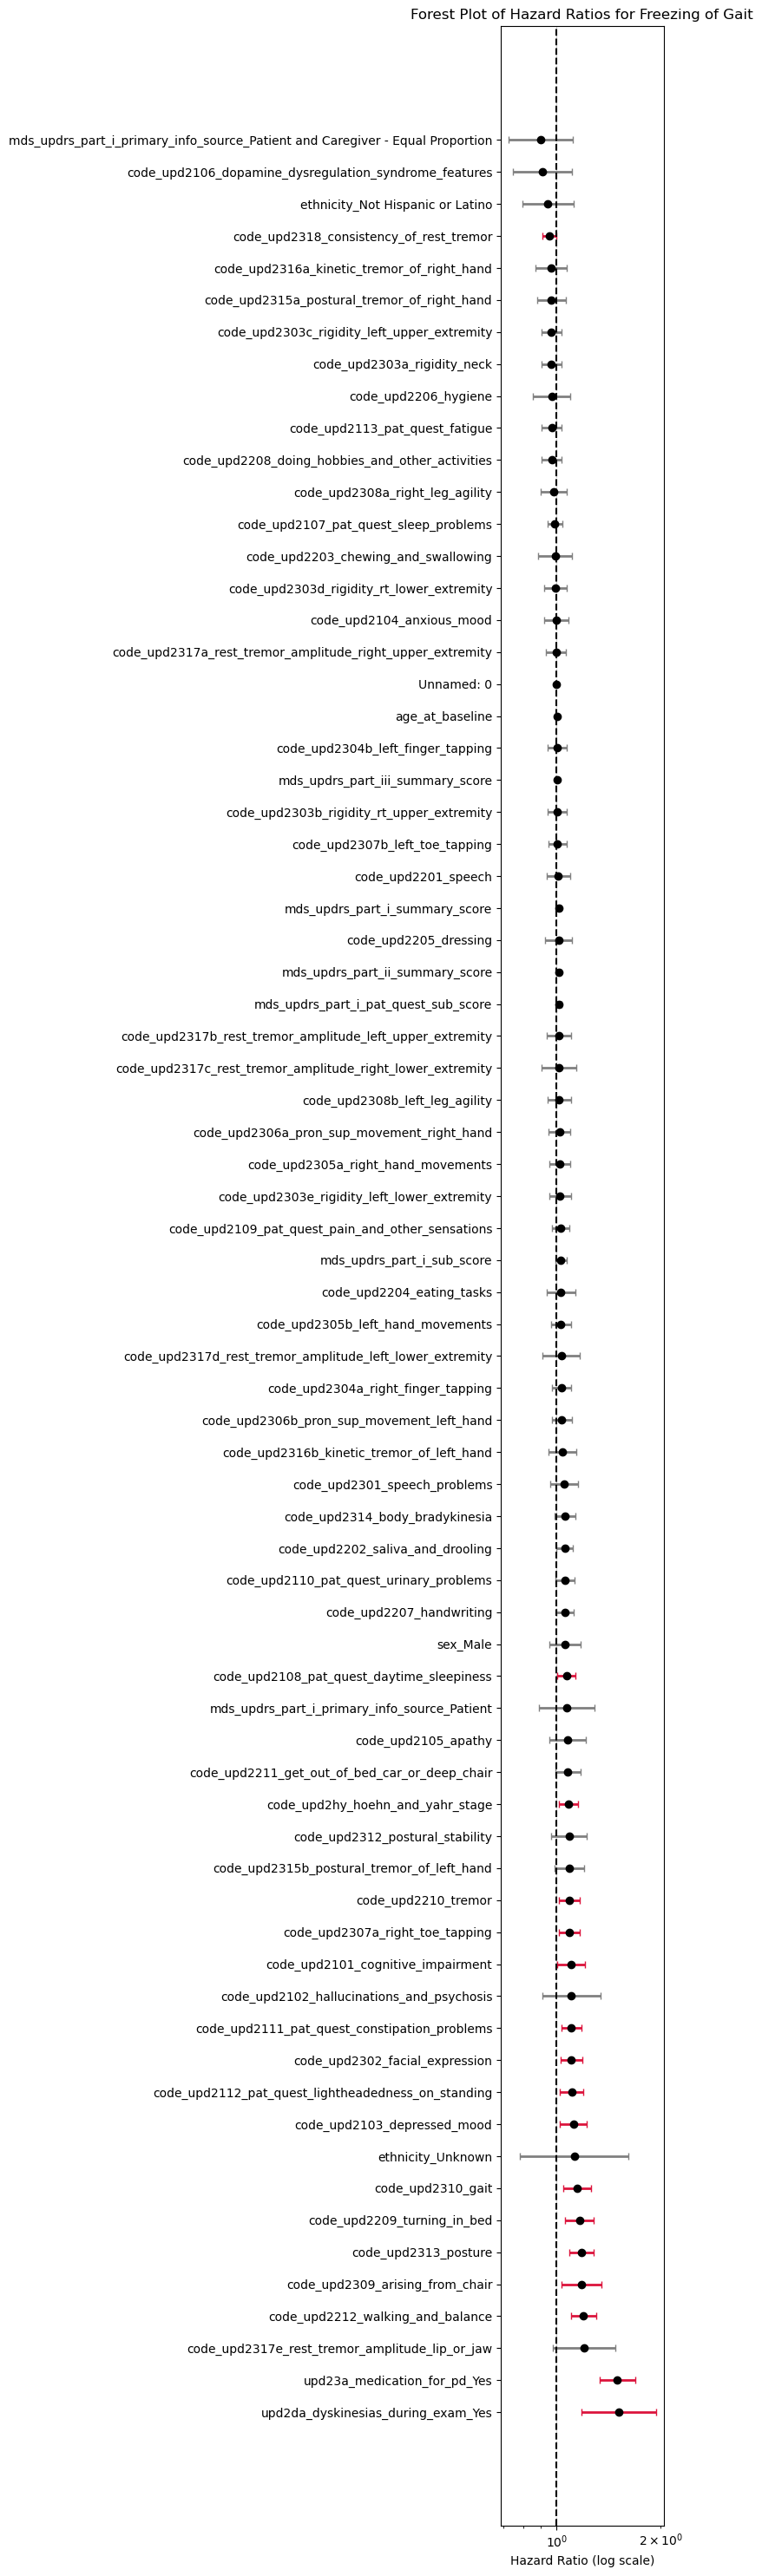

In [11]:
summary = results

# Get HR and 95% CI
summary['HR'] = np.exp(summary['coef'])
summary['HR_lower'] = np.exp(summary['coef lower 95%'])
summary['HR_upper'] = np.exp(summary['coef upper 95%'])
summary['significant'] = summary['p'] < 0.05

# Sort (optional: by effect size or p-value)
summary = summary.sort_values('HR', ascending=False)


plt.figure(figsize=(8, len(summary)*0.4 + 1))

for i, row in summary.iterrows():
    plt.errorbar(
        x=row['HR'],
        y=i,
        xerr=[[row['HR'] - row['HR_lower']], [row['HR_upper'] - row['HR']]],
        fmt='o',
        color='black',
        ecolor='crimson' if row['significant'] else 'gray',
        elinewidth=2,
        capsize=3
    )

# Vertical line at HR = 1
plt.axvline(1, color='black', linestyle='--')

# Axes settings
plt.xlabel('Hazard Ratio (log scale)')
plt.xscale('log')
plt.yticks(ticks=range(len(summary)), labels=summary.index)
plt.title('Forest Plot of Hazard Ratios for Freezing of Gait')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



From now on, we select the columns with p-value < 0.5. 

In [7]:
results = results[results['p'] < 0.05]

In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, code_upd2101_cognitive_impairment to upd23a_medication_for_pd_Yes
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coef                 17 non-null     float64
 1   exp(coef)            17 non-null     float64
 2   se(coef)             17 non-null     float64
 3   coef lower 95%       17 non-null     float64
 4   coef upper 95%       17 non-null     float64
 5   exp(coef) lower 95%  17 non-null     float64
 6   exp(coef) upper 95%  17 non-null     float64
 7   cmp to               17 non-null     float64
 8   z                    17 non-null     float64
 9   p                    17 non-null     float64
 10  -log2(p)             17 non-null     float64
dtypes: float64(11)
memory usage: 1.6+ KB


Next, we select only those covariates that satisfy the proportional hazards assumption

In [9]:
results_ph = proportional_hazard_test(cph, df, time_transform='rank')

ph_test_df = results_ph.summary


ph_test_pass = ph_test_df[ph_test_df['p'] > 0.05]
ph_test_pass.info()



<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, age_at_baseline to upd2da_dyskinesias_during_exam_Yes
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   test_statistic  71 non-null     float64
 1   p               71 non-null     float64
 2   -log2(p)        71 non-null     float64
dtypes: float64(3)
memory usage: 2.2+ KB


In [10]:
ph_test_pass.head()

,test_statistic,p,-log2(p)
age_at_baseline,0.010272,0.919273,0.121435
code_upd2101_cognitive_impairment,0.379586,0.537825,0.894791
code_upd2102_hallucinations_and_psychosis,1.346752,0.245847,2.024169
code_upd2103_depressed_mood,0.209638,0.647051,0.628048
code_upd2104_anxious_mood,0.003344,0.953888,0.068109


In [11]:

significant_covariates = results.index

ph_ok_covariates = ph_test_pass.index

final_covariates = significant_covariates.intersection(ph_ok_covariates)




Finally, we select only those covariantes which are statistically significant and also pass the proportional hazard test.

In [12]:
results_ph_ok = results.loc[final_covariates]

In [14]:
results_ph_ok.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, code_upd2101_cognitive_impairment to upd23a_medication_for_pd_Yes
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coef                 17 non-null     float64
 1   exp(coef)            17 non-null     float64
 2   se(coef)             17 non-null     float64
 3   coef lower 95%       17 non-null     float64
 4   coef upper 95%       17 non-null     float64
 5   exp(coef) lower 95%  17 non-null     float64
 6   exp(coef) upper 95%  17 non-null     float64
 7   cmp to               17 non-null     float64
 8   z                    17 non-null     float64
 9   p                    17 non-null     float64
 10  -log2(p)             17 non-null     float64
dtypes: float64(11)
memory usage: 1.6+ KB


In [15]:
print(results_ph_ok)

                                                        coef  exp(coef)  \
code_upd2101_cognitive_impairment                   0.094878   1.099525   
code_upd2103_depressed_mood                         0.110693   1.117052   
code_upd2108_pat_quest_daytime_sleepiness           0.065475   1.067666   
code_upd2111_pat_quest_constipation_problems        0.097469   1.102377   
code_upd2112_pat_quest_lightheadedness_on_standing  0.098736   1.103775   
code_upd2209_turning_in_bed                         0.152526   1.164773   
code_upd2210_tremor                                 0.084599   1.088280   
code_upd2212_walking_and_balance                    0.178752   1.195724   
code_upd2302_facial_expression                      0.097726   1.102661   
code_upd2307a_right_toe_tapping                     0.085469   1.089228   
code_upd2309_arising_from_chair                     0.165465   1.179942   
code_upd2310_gait                                   0.136671   1.146451   
code_upd2313_posture     

In [16]:
results_ph_ok.to_csv("important_columns.csv")